Note: must turn off radar in settings before recording

In [ ]:
# Mounting Drive (where training data was stored)
from google.colab import drive 
drive.mount('/content/drive')

# Tensorflow 2.x is used 
%tensorflow_version 2.x

# Training is done on a GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

# Imports
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten

import os
import random
from random import shuffle

import numpy as np
from PIL import Image
import cv2
import statistics
import matplotlib.pyplot as plt 

#import typing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Next steps: use GAN to debias dataset (MIT 6.S191 lec 4, lab 2)

# Function for data processing which opens up a specified number of files and resizes the images
# Returns a less skewed labeled training set
def data_processing(start_val,num_files):
  """
  In order to ensure the training set isn't skewed towards any one action, each datapoint will be added to a list of similar actions
  The training set will be made up of equal numbers of datapoints from each list
  These lists are initialized here
  """
  sharp_turn_l = []
  sharp_turn_r = []
  medium_turn_l = []
  medium_turn_r = []
  slight_turn_l = []
  slight_turn_r = []
  no_turn = []

  balanced_data = []
  file_number_to_open = start_val
  continue_loop = True
  
  #Loops through all files and stores their data
  while continue_loop:
    data_file_location = '/content/drive/MyDrive/GTA Driving Data/processed-training_data-{}.npy'.format(file_number_to_open)

    # Checks to see if the data file exists
    if os.path.isfile(data_file_location) and file_number_to_open < start_val + num_files:
      processed_data = np.load(data_file_location,allow_pickle=True)
     
      print("File {} opened".format(file_number_to_open))
      file_number_to_open += 1

      # Iterates through datapoints in each file
      for entry in processed_data:

        y = entry[0] # entry[0] is a list of values (left stick position, right stick position, etc..) from the controller
        y_ls = round(y[2],2) # Currently, only the left_stick's x-value is used as a label
        x_raw= entry[1] # entry[1] is the image 

        # Randomly changes the size of 1 in every 4 images, and then resizes the image to (160,120). 
        # This was found to greatly reduce overfitting
        if (random.randrange(4)==2):
          x_val = random.randrange(155,165)
          y_val = random.randrange(115,125)
          x_resized = cv2.resize(x_raw,(x_val, y_val))
          x = cv2.resize(x_resized,(160, 120))
        else:
          x = cv2.resize(x_raw,(160, 120))        
        
        # Each datapoint is added to a list of similar actions based on the left stick's position

        if y_ls > 0.8:
          # Sharp turn
          sharp_turn_r.append([x,y_ls])
        elif y_ls < 0.2:
          # Sharp turn
          sharp_turn_l.append([x,y_ls])

        elif y_ls > 0.68:
          # Medium turn
          medium_turn_r.append([x,y_ls])          
        elif y_ls < 0.32:
          # Medium turn
          medium_turn_l.append([x,y_ls])

        elif y_ls > 0.56:
          # Light turn
          slight_turn_r.append([x,y_ls])          
        elif y_ls < 0.34:
          # Light turn
          slight_turn_l.append([x,y_ls])
          
        else:
          no_turn.append([x,y_ls])
    else:
      if (file_number_to_open > start_val + num_files):
        # Breaks loop if current file is not found and there are no more files
        continue_loop = False
        break

      else:
        # Goes to next file if the current file is not found and there are still more files
        print("file {} not found".format(file_number_to_open))
        file_number_to_open += 1
  
  # Shuffling lists prior to pruning in order to ensure that all files are used in training
  shuffle(slight_turn_l)
  shuffle(slight_turn_r)
  shuffle(medium_turn_l)
  shuffle(medium_turn_r)
  shuffle(no_turn)
  
  # Balancing l/r data
  slight_turn_l = slight_turn_l[0:len(slight_turn_r)]
  slight_turn_r = slight_turn_r[0:len(slight_turn_l)]
  medium_turn_l = medium_turn_l[0:len(medium_turn_r)]
  medium_turn_r = medium_turn_r[0:len(medium_turn_l)]

  balanced_data = no_turn[0:len(slight_turn_l+slight_turn_r)] + slight_turn_l + slight_turn_r + medium_turn_l + medium_turn_r + sharp_turn_l + sharp_turn_r
  

  # Shuffling balanced_data so that validation set isn't only made up of sharp_turn_r
  shuffle(balanced_data)
  
  X = []
  Y = []

  X , Y = zip(*balanced_data)

  print("Done! have {} test cases".format(len(balanced_data)))
  
  return X,Y
 

In [ ]:
# Defines the neural network that will be trained on the player's data 
# Returns uncompiled network
def build_driving_model():
  """
  Transfer learning: a ResNet50 trained on imagenet is used with its last 4 layers removed.
  Trainable fully connected layers are added on top of the imagenet conv layers
  Dropout was initially used but was later removed for performance reasons
  https://towardsdatascience.com/pitfalls-with-dropout-and-batchnorm-in-regression-problems-39e02ce08e4d
  """
  resnet = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(120, 160, 3))

  for layer in resnet.layers[:-4]:
      layer.trainable = False
  
  # Prints network details for debugging
  """
  for layer in resnet.layers:
      print(layer, layer.trainable)
  """
  
  model = Sequential()
  model.add(resnet)
  # model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(200, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(50, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(10, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(1))
  return model

"""
These metrics check the accuracy of the network. 
The second metric (which has a larger allowed error) determines whether the network's prediction is 'in the ballpark'
"""
accepted_diff = 0.03 
def linear_regression_equality(y_true, y_pred):
    diff = K.abs(y_true-y_pred)
    return K.mean(K.cast(diff < accepted_diff, tf.float32))

wide_accepted_diff = 0.05 
def wide_linear_regression_equality(y_true, y_pred):
    diff = K.abs(y_true-y_pred)
    return K.mean(K.cast(diff < wide_accepted_diff, tf.float32))

try weight regularization + image flipping
try to have intermediate size changes


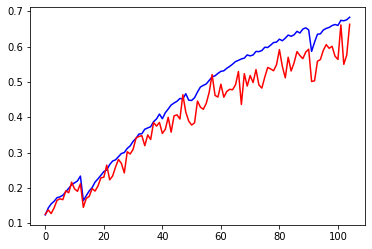

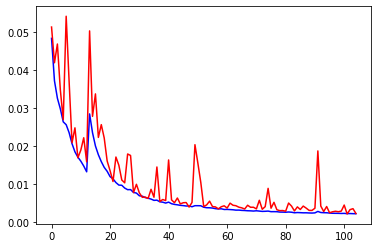

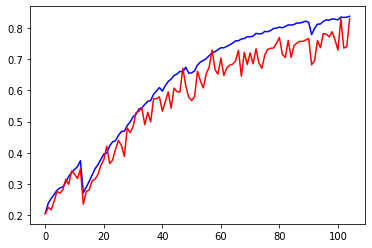

----- --------STARTING EPOCH 106-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 17s 64ms/step - loss: 0.0019 - linear_regression_equality: 0.6706 - wide_linear_regression_equality: 0.8453 - val_loss: 0.0016 - val_linear_regression_equality: 0.7411 - val_wide_linear_regression_equality: 0.8656
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 57ms/step - loss: 0.0020 - linear_regression_equality: 0.6681 - wide_linear_regression_equality: 0.8341 - val_loss: 0.0028 - val_linear_regression_equality: 0.4883 - val_wide_linear_regression_equality: 0.7251
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 10s 58ms/step - loss: 0.0018 - linear_regression_equality: 0.7042 - wide_linear_regression_equalit

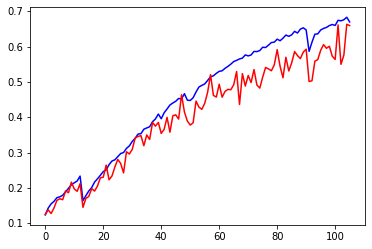

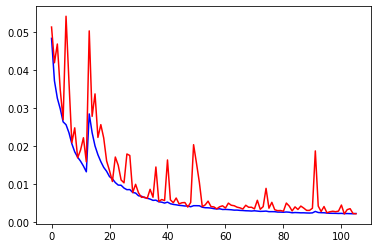

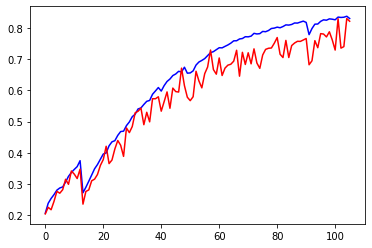

----- --------STARTING EPOCH 107-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 58ms/step - loss: 0.0019 - linear_regression_equality: 0.6812 - wide_linear_regression_equality: 0.8442 - val_loss: 0.0017 - val_linear_regression_equality: 0.7162 - val_wide_linear_regression_equality: 0.8475
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 58ms/step - loss: 0.0020 - linear_regression_equality: 0.6660 - wide_linear_regression_equality: 0.8356 - val_loss: 0.0032 - val_linear_regression_equality: 0.4138 - val_wide_linear_regression_equality: 0.6731
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 10s 60ms/step - loss: 0.0019 - linear_regression_equality: 0.6923 - wide_linear_regression_equalit

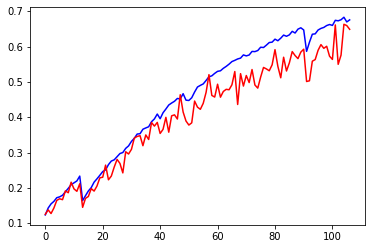

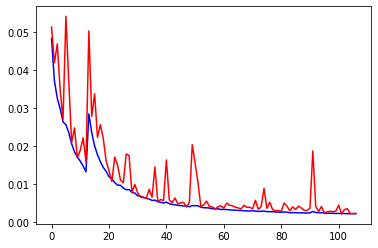

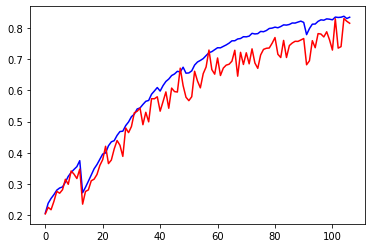

----- --------STARTING EPOCH 108-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 58ms/step - loss: 0.0018 - linear_regression_equality: 0.6828 - wide_linear_regression_equality: 0.8470 - val_loss: 0.0014 - val_linear_regression_equality: 0.7493 - val_wide_linear_regression_equality: 0.8847
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 60ms/step - loss: 0.0021 - linear_regression_equality: 0.6703 - wide_linear_regression_equality: 0.8379 - val_loss: 0.0018 - val_linear_regression_equality: 0.7414 - val_wide_linear_regression_equality: 0.8553
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 62ms/step - loss: 0.0018 - linear_regression_equality: 0.7160 - wide_linear_regression_equalit

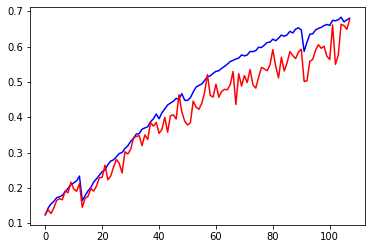

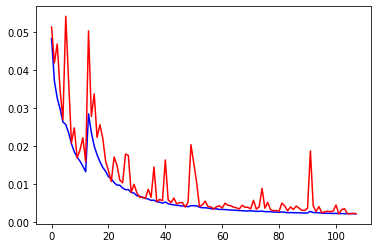

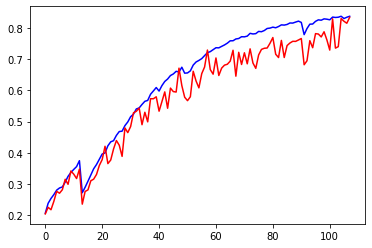

----- --------STARTING EPOCH 109-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.6875 - wide_linear_regression_equality: 0.8497 - val_loss: 0.0018 - val_linear_regression_equality: 0.7277 - val_wide_linear_regression_equality: 0.8527
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0020 - linear_regression_equality: 0.6651 - wide_linear_regression_equality: 0.8401 - val_loss: 0.0020 - val_linear_regression_equality: 0.7224 - val_wide_linear_regression_equality: 0.8527
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 10s 60ms/step - loss: 0.0018 - linear_regression_equality: 0.7160 - wide_linear_regression_equalit

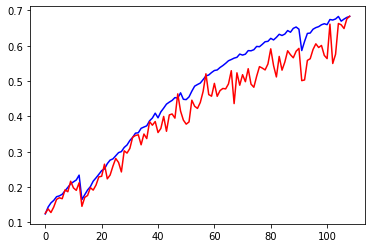

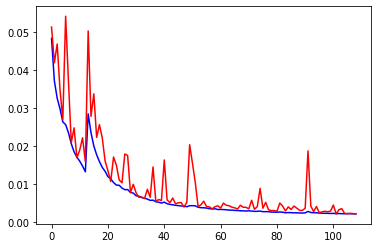

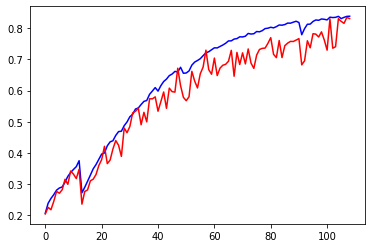

----- --------STARTING EPOCH 110-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.6844 - wide_linear_regression_equality: 0.8446 - val_loss: 0.0017 - val_linear_regression_equality: 0.7470 - val_wide_linear_regression_equality: 0.8598
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0020 - linear_regression_equality: 0.6803 - wide_linear_regression_equality: 0.8414 - val_loss: 0.0021 - val_linear_regression_equality: 0.7098 - val_wide_linear_regression_equality: 0.8392
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7276 - wide_linear_regression_equalit

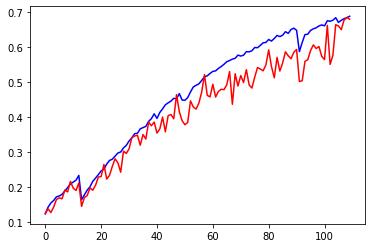

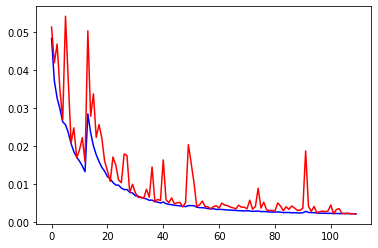

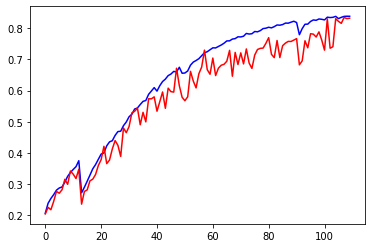

----- --------STARTING EPOCH 111-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 62ms/step - loss: 0.0018 - linear_regression_equality: 0.6959 - wide_linear_regression_equality: 0.8517 - val_loss: 0.0014 - val_linear_regression_equality: 0.7524 - val_wide_linear_regression_equality: 0.8747
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 60ms/step - loss: 0.0020 - linear_regression_equality: 0.6758 - wide_linear_regression_equality: 0.8416 - val_loss: 0.0022 - val_linear_regression_equality: 0.6099 - val_wide_linear_regression_equality: 0.8155
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 64ms/step - loss: 0.0017 - linear_regression_equality: 0.7227 - wide_linear_regression_equalit

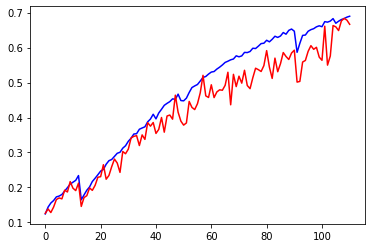

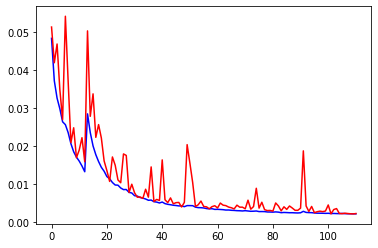

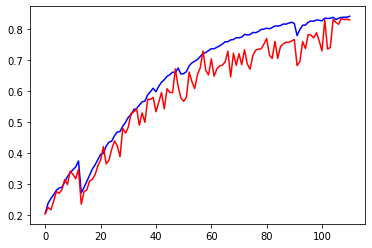

----- --------STARTING EPOCH 112-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0018 - linear_regression_equality: 0.6953 - wide_linear_regression_equality: 0.8521 - val_loss: 0.0019 - val_linear_regression_equality: 0.7278 - val_wide_linear_regression_equality: 0.8433
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0020 - linear_regression_equality: 0.6849 - wide_linear_regression_equality: 0.8449 - val_loss: 0.0021 - val_linear_regression_equality: 0.7273 - val_wide_linear_regression_equality: 0.8439
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 63ms/step - loss: 0.0017 - linear_regression_equality: 0.7199 - wide_linear_regression_equalit

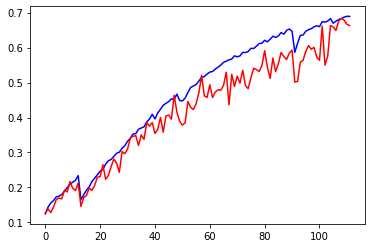

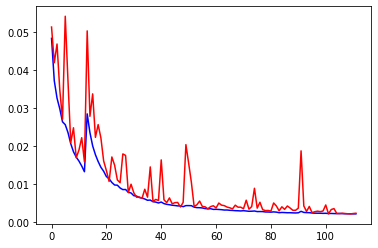

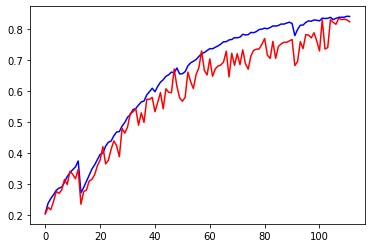

----- --------STARTING EPOCH 113-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0018 - linear_regression_equality: 0.7015 - wide_linear_regression_equality: 0.8533 - val_loss: 0.0017 - val_linear_regression_equality: 0.7339 - val_wide_linear_regression_equality: 0.8609
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.6912 - wide_linear_regression_equality: 0.8534 - val_loss: 0.0017 - val_linear_regression_equality: 0.7355 - val_wide_linear_regression_equality: 0.8625
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7350 - wide_linear_regression_equalit

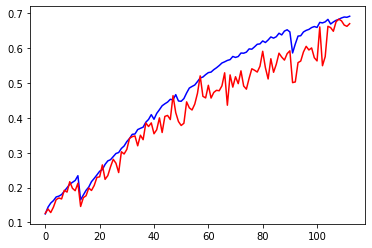

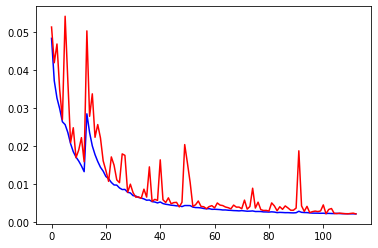

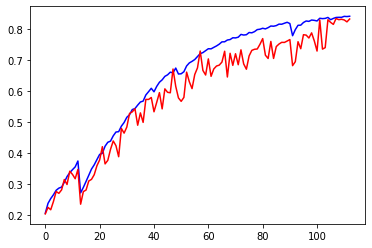

----- --------STARTING EPOCH 114-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0017 - linear_regression_equality: 0.7045 - wide_linear_regression_equality: 0.8560 - val_loss: 0.0017 - val_linear_regression_equality: 0.7360 - val_wide_linear_regression_equality: 0.8749
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0020 - linear_regression_equality: 0.6838 - wide_linear_regression_equality: 0.8462 - val_loss: 0.0023 - val_linear_regression_equality: 0.6161 - val_wide_linear_regression_equality: 0.8163
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 64ms/step - loss: 0.0018 - linear_regression_equality: 0.7123 - wide_linear_regression_equalit

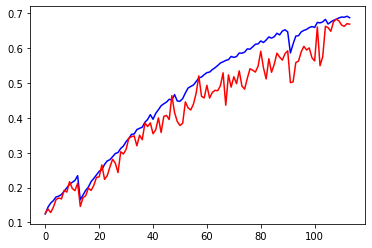

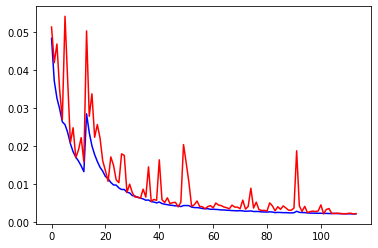

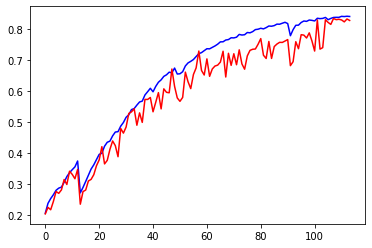

----- --------STARTING EPOCH 115-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7009 - wide_linear_regression_equality: 0.8547 - val_loss: 0.0017 - val_linear_regression_equality: 0.7443 - val_wide_linear_regression_equality: 0.8682
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.6925 - wide_linear_regression_equality: 0.8458 - val_loss: 0.0034 - val_linear_regression_equality: 0.3655 - val_wide_linear_regression_equality: 0.6410
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 62ms/step - loss: 0.0019 - linear_regression_equality: 0.6981 - wide_linear_regression_equalit

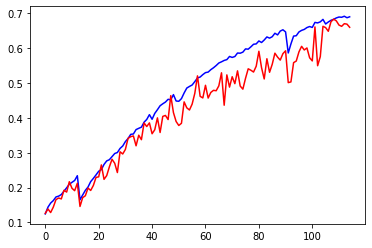

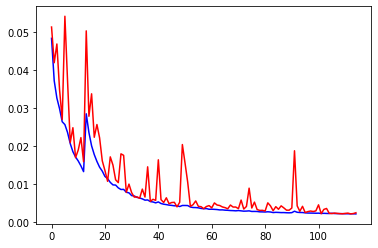

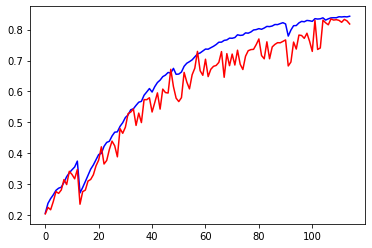

----- --------STARTING EPOCH 116-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0018 - linear_regression_equality: 0.7064 - wide_linear_regression_equality: 0.8553 - val_loss: 0.0017 - val_linear_regression_equality: 0.7445 - val_wide_linear_regression_equality: 0.8702
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0020 - linear_regression_equality: 0.6801 - wide_linear_regression_equality: 0.8409 - val_loss: 0.0018 - val_linear_regression_equality: 0.7207 - val_wide_linear_regression_equality: 0.8509
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7200 - wide_linear_regression_equalit

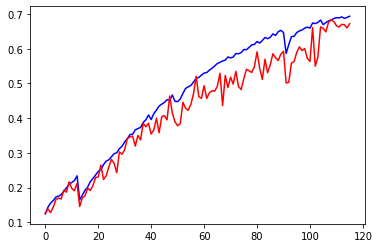

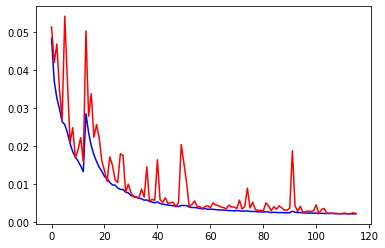

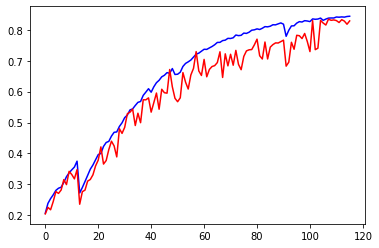

----- --------STARTING EPOCH 117-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7046 - wide_linear_regression_equality: 0.8508 - val_loss: 0.0015 - val_linear_regression_equality: 0.7577 - val_wide_linear_regression_equality: 0.8597
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 62ms/step - loss: 0.0019 - linear_regression_equality: 0.6948 - wide_linear_regression_equality: 0.8503 - val_loss: 0.0020 - val_linear_regression_equality: 0.7184 - val_wide_linear_regression_equality: 0.8562
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 64ms/step - loss: 0.0017 - linear_regression_equality: 0.7254 - wide_linear_regression_equalit

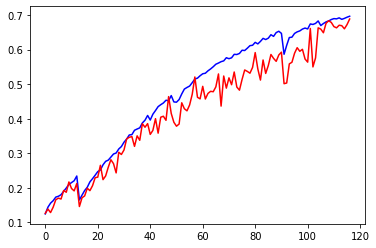

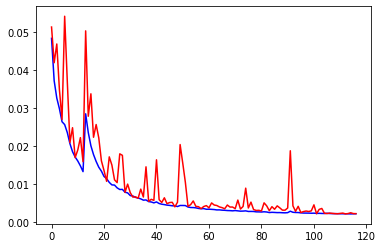

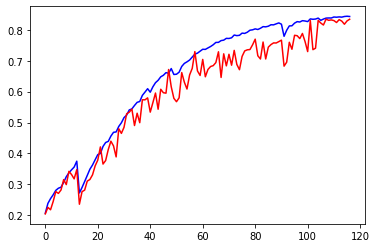

----- --------STARTING EPOCH 118-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7153 - wide_linear_regression_equality: 0.8575 - val_loss: 0.0015 - val_linear_regression_equality: 0.7616 - val_wide_linear_regression_equality: 0.8735
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.6966 - wide_linear_regression_equality: 0.8531 - val_loss: 0.0018 - val_linear_regression_equality: 0.7449 - val_wide_linear_regression_equality: 0.8615
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7266 - wide_linear_regression_equalit

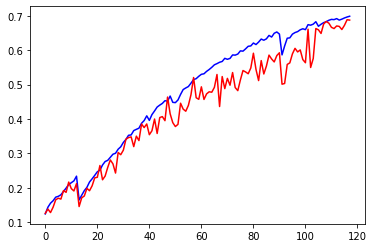

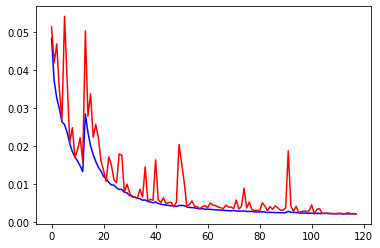

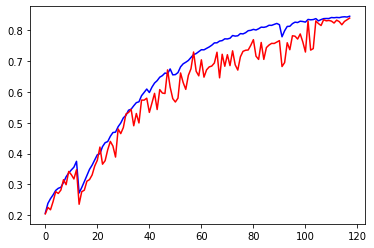

----- --------STARTING EPOCH 119-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7106 - wide_linear_regression_equality: 0.8627 - val_loss: 0.0016 - val_linear_regression_equality: 0.7632 - val_wide_linear_regression_equality: 0.8687
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.6867 - wide_linear_regression_equality: 0.8424 - val_loss: 0.0020 - val_linear_regression_equality: 0.6911 - val_wide_linear_regression_equality: 0.8378
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7267 - wide_linear_regression_equalit

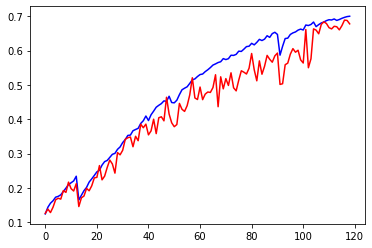

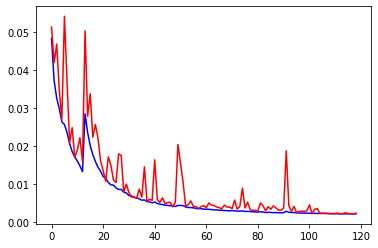

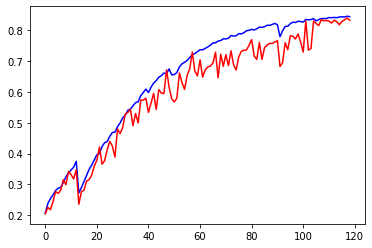

----- --------STARTING EPOCH 120-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7160 - wide_linear_regression_equality: 0.8619 - val_loss: 0.0016 - val_linear_regression_equality: 0.7536 - val_wide_linear_regression_equality: 0.8662
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 62ms/step - loss: 0.0018 - linear_regression_equality: 0.6979 - wide_linear_regression_equality: 0.8496 - val_loss: 0.0046 - val_linear_regression_equality: 0.2697 - val_wide_linear_regression_equality: 0.5237
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7090 - wide_linear_regression_equalit

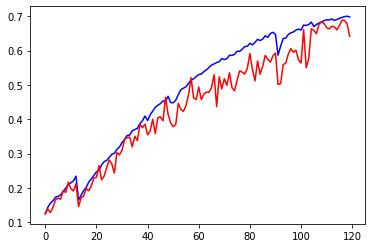

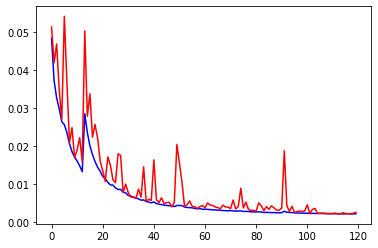

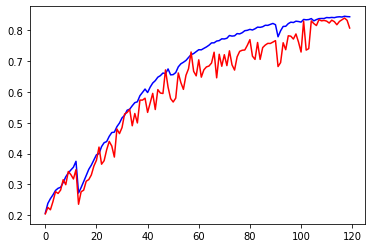

----- --------STARTING EPOCH 121-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7123 - wide_linear_regression_equality: 0.8601 - val_loss: 0.0016 - val_linear_regression_equality: 0.7513 - val_wide_linear_regression_equality: 0.8664
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 62ms/step - loss: 0.0020 - linear_regression_equality: 0.7005 - wide_linear_regression_equality: 0.8503 - val_loss: 0.0018 - val_linear_regression_equality: 0.7502 - val_wide_linear_regression_equality: 0.8649
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7351 - wide_linear_regression_equalit

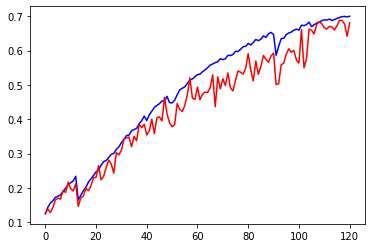

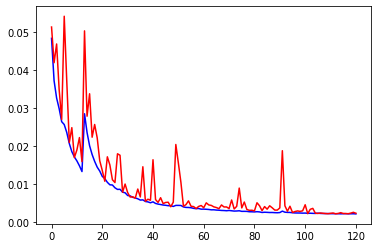

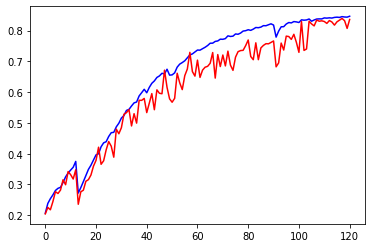

----- --------STARTING EPOCH 122-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7223 - wide_linear_regression_equality: 0.8631 - val_loss: 0.0014 - val_linear_regression_equality: 0.7594 - val_wide_linear_regression_equality: 0.8830
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.6977 - wide_linear_regression_equality: 0.8550 - val_loss: 0.0016 - val_linear_regression_equality: 0.7646 - val_wide_linear_regression_equality: 0.8827
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 10s 60ms/step - loss: 0.0017 - linear_regression_equality: 0.7358 - wide_linear_regression_equalit

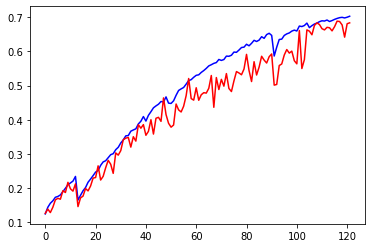

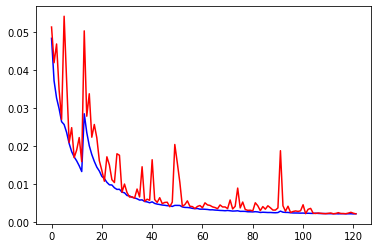

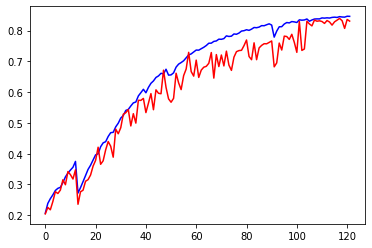

----- --------STARTING EPOCH 123-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 62ms/step - loss: 0.0017 - linear_regression_equality: 0.7158 - wide_linear_regression_equality: 0.8579 - val_loss: 0.0018 - val_linear_regression_equality: 0.7567 - val_wide_linear_regression_equality: 0.8628
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 62ms/step - loss: 0.0019 - linear_regression_equality: 0.7012 - wide_linear_regression_equality: 0.8530 - val_loss: 0.0016 - val_linear_regression_equality: 0.7582 - val_wide_linear_regression_equality: 0.8696
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7356 - wide_linear_regression_equalit

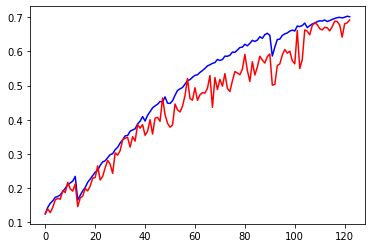

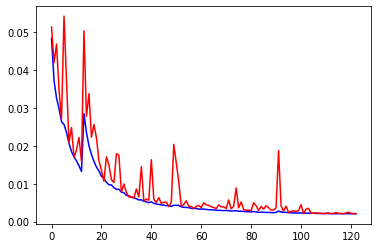

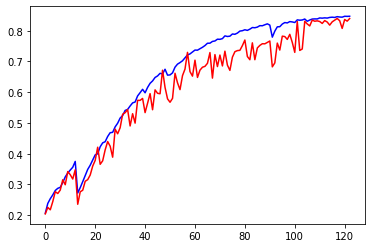

----- --------STARTING EPOCH 124-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7237 - wide_linear_regression_equality: 0.8623 - val_loss: 0.0018 - val_linear_regression_equality: 0.7513 - val_wide_linear_regression_equality: 0.8768
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 60ms/step - loss: 0.0019 - linear_regression_equality: 0.6998 - wide_linear_regression_equality: 0.8487 - val_loss: 0.0017 - val_linear_regression_equality: 0.7080 - val_wide_linear_regression_equality: 0.8571
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 63ms/step - loss: 0.0017 - linear_regression_equality: 0.7306 - wide_linear_regression_equalit

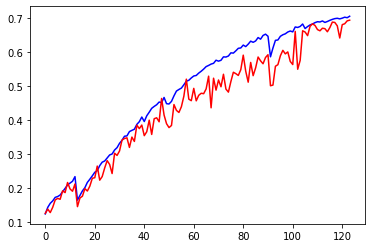

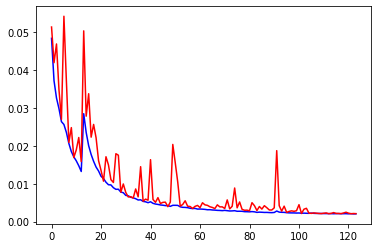

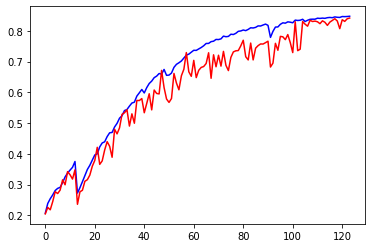

----- --------STARTING EPOCH 125-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7111 - wide_linear_regression_equality: 0.8548 - val_loss: 0.0014 - val_linear_regression_equality: 0.7582 - val_wide_linear_regression_equality: 0.8749
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.7022 - wide_linear_regression_equality: 0.8503 - val_loss: 0.0023 - val_linear_regression_equality: 0.5418 - val_wide_linear_regression_equality: 0.7761
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7219 - wide_linear_regression_equalit

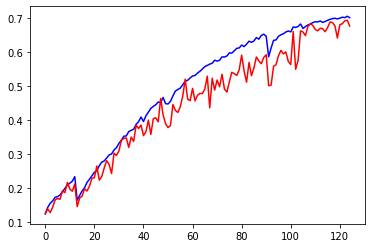

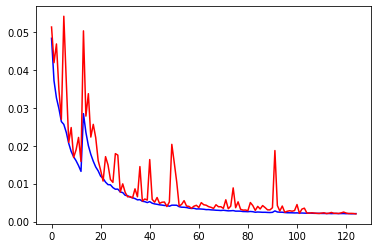

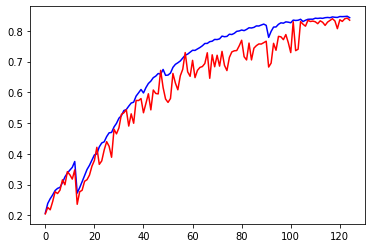

----- --------STARTING EPOCH 126-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0017 - linear_regression_equality: 0.7282 - wide_linear_regression_equality: 0.8650 - val_loss: 0.0014 - val_linear_regression_equality: 0.7653 - val_wide_linear_regression_equality: 0.8726
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 60ms/step - loss: 0.0019 - linear_regression_equality: 0.7024 - wide_linear_regression_equality: 0.8469 - val_loss: 0.0019 - val_linear_regression_equality: 0.7436 - val_wide_linear_regression_equality: 0.8615
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7322 - wide_linear_regression_equalit

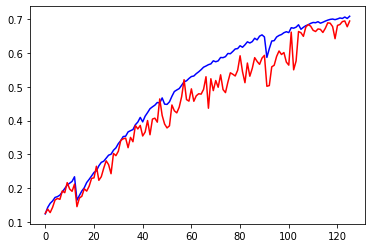

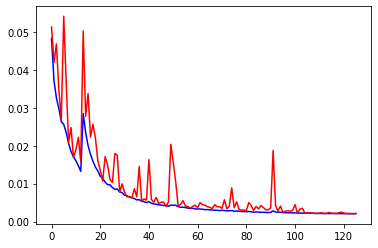

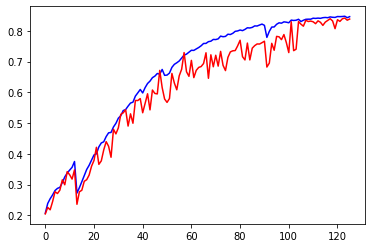

----- --------STARTING EPOCH 127-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 12s 63ms/step - loss: 0.0017 - linear_regression_equality: 0.7206 - wide_linear_regression_equality: 0.8599 - val_loss: 0.0017 - val_linear_regression_equality: 0.7351 - val_wide_linear_regression_equality: 0.8504
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 60ms/step - loss: 0.0019 - linear_regression_equality: 0.7024 - wide_linear_regression_equality: 0.8496 - val_loss: 0.0018 - val_linear_regression_equality: 0.6813 - val_wide_linear_regression_equality: 0.8449
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 63ms/step - loss: 0.0017 - linear_regression_equality: 0.7334 - wide_linear_regression_equalit

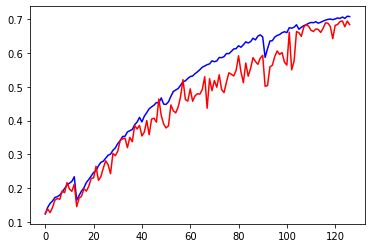

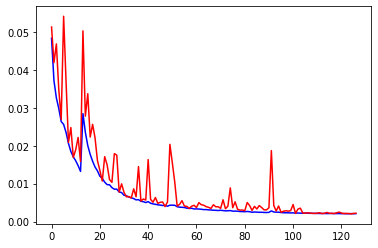

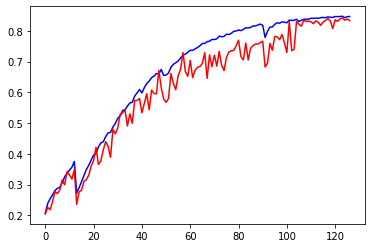

----- --------STARTING EPOCH 128-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0017 - linear_regression_equality: 0.7255 - wide_linear_regression_equality: 0.8614 - val_loss: 0.0016 - val_linear_regression_equality: 0.7780 - val_wide_linear_regression_equality: 0.8821
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.7043 - wide_linear_regression_equality: 0.8501 - val_loss: 0.0019 - val_linear_regression_equality: 0.6500 - val_wide_linear_regression_equality: 0.8426
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7333 - wide_linear_regression_equalit

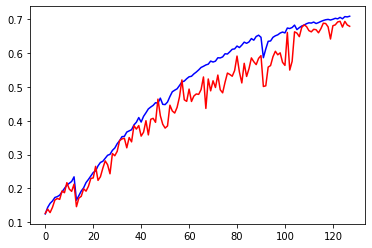

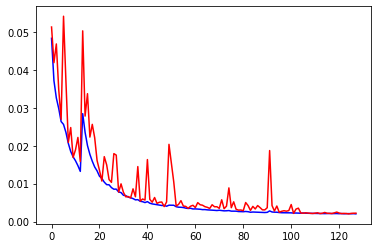

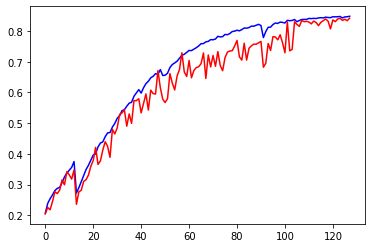

----- --------STARTING EPOCH 129-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0016 - linear_regression_equality: 0.7360 - wide_linear_regression_equality: 0.8676 - val_loss: 0.0018 - val_linear_regression_equality: 0.7540 - val_wide_linear_regression_equality: 0.8683
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 63ms/step - loss: 0.0019 - linear_regression_equality: 0.6988 - wide_linear_regression_equality: 0.8473 - val_loss: 0.0017 - val_linear_regression_equality: 0.7498 - val_wide_linear_regression_equality: 0.8604
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7303 - wide_linear_regression_equalit

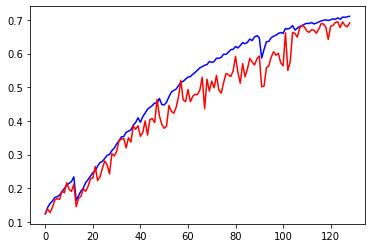

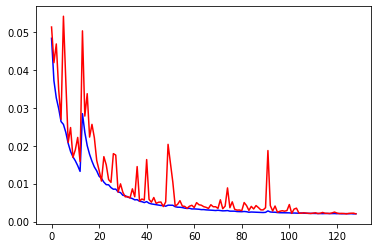

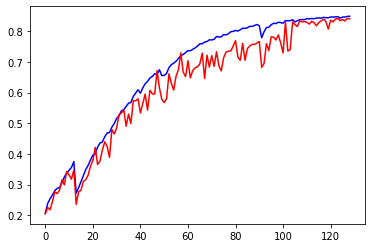

----- --------STARTING EPOCH 130-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0016 - linear_regression_equality: 0.7264 - wide_linear_regression_equality: 0.8610 - val_loss: 0.0017 - val_linear_regression_equality: 0.7616 - val_wide_linear_regression_equality: 0.8662
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 60ms/step - loss: 0.0019 - linear_regression_equality: 0.7109 - wide_linear_regression_equality: 0.8551 - val_loss: 0.0019 - val_linear_regression_equality: 0.7546 - val_wide_linear_regression_equality: 0.8597
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7357 - wide_linear_regression_equalit

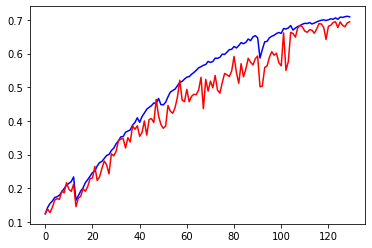

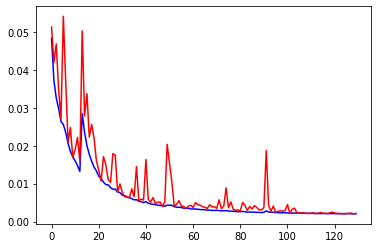

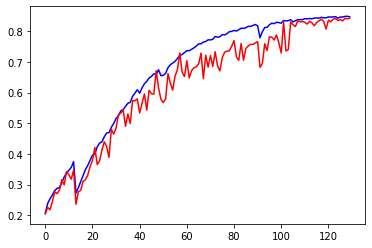

----- --------STARTING EPOCH 131-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0016 - linear_regression_equality: 0.7299 - wide_linear_regression_equality: 0.8671 - val_loss: 0.0015 - val_linear_regression_equality: 0.7603 - val_wide_linear_regression_equality: 0.8741
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 64ms/step - loss: 0.0018 - linear_regression_equality: 0.7166 - wide_linear_regression_equality: 0.8603 - val_loss: 0.0018 - val_linear_regression_equality: 0.7598 - val_wide_linear_regression_equality: 0.8710
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 62ms/step - loss: 0.0017 - linear_regression_equality: 0.7279 - wide_linear_regression_equalit

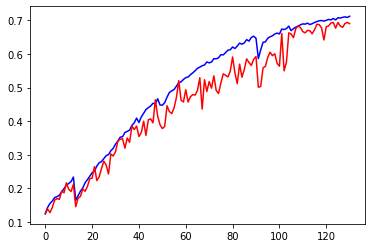

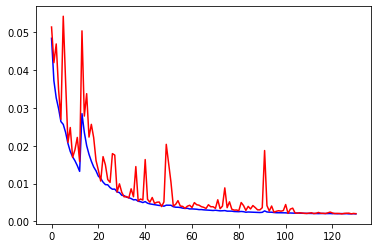

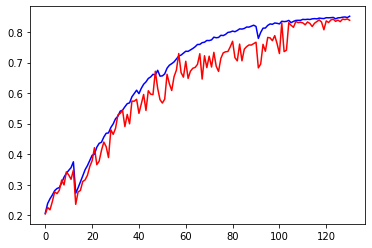

----- --------STARTING EPOCH 132-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7266 - wide_linear_regression_equality: 0.8602 - val_loss: 0.0015 - val_linear_regression_equality: 0.7543 - val_wide_linear_regression_equality: 0.8664
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 60ms/step - loss: 0.0018 - linear_regression_equality: 0.7174 - wide_linear_regression_equality: 0.8560 - val_loss: 0.0017 - val_linear_regression_equality: 0.7450 - val_wide_linear_regression_equality: 0.8672
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7362 - wide_linear_regression_equalit

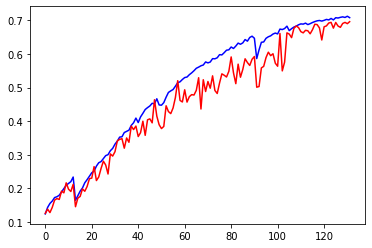

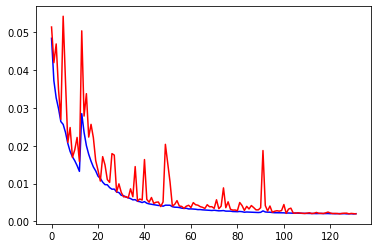

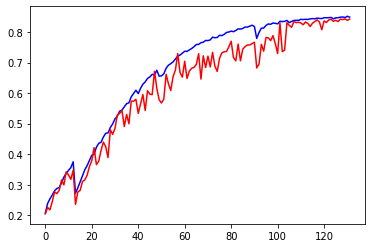

----- --------STARTING EPOCH 133-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7269 - wide_linear_regression_equality: 0.8615 - val_loss: 0.0014 - val_linear_regression_equality: 0.7750 - val_wide_linear_regression_equality: 0.8762
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 60ms/step - loss: 0.0019 - linear_regression_equality: 0.7127 - wide_linear_regression_equality: 0.8545 - val_loss: 0.0017 - val_linear_regression_equality: 0.7538 - val_wide_linear_regression_equality: 0.8591
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7422 - wide_linear_regression_equalit

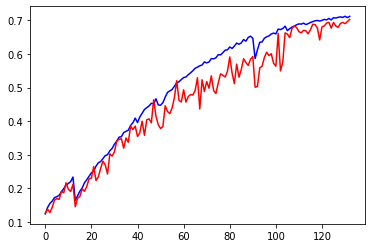

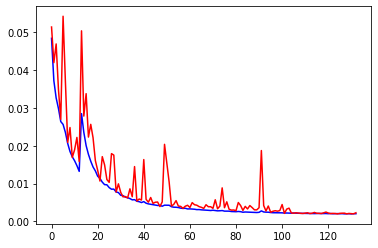

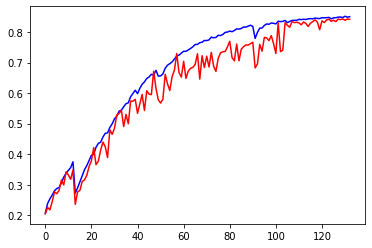

----- --------STARTING EPOCH 134-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 63ms/step - loss: 0.0017 - linear_regression_equality: 0.7322 - wide_linear_regression_equality: 0.8612 - val_loss: 0.0016 - val_linear_regression_equality: 0.7604 - val_wide_linear_regression_equality: 0.8647
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.7105 - wide_linear_regression_equality: 0.8560 - val_loss: 0.0018 - val_linear_regression_equality: 0.7333 - val_wide_linear_regression_equality: 0.8636
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 60ms/step - loss: 0.0017 - linear_regression_equality: 0.7402 - wide_linear_regression_equalit

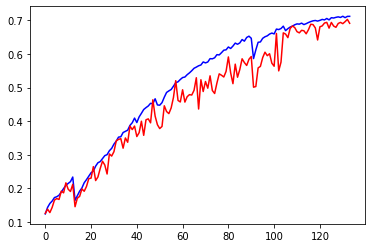

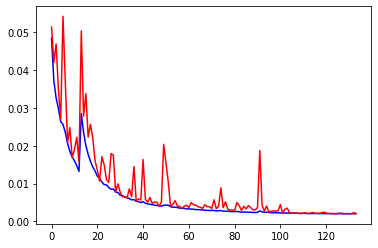

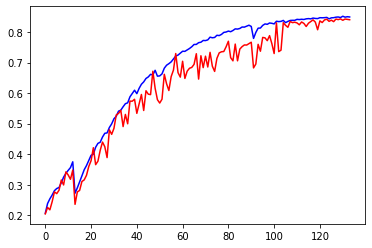

----- --------STARTING EPOCH 135-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0016 - linear_regression_equality: 0.7288 - wide_linear_regression_equality: 0.8673 - val_loss: 0.0016 - val_linear_regression_equality: 0.7671 - val_wide_linear_regression_equality: 0.8609
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 62ms/step - loss: 0.0018 - linear_regression_equality: 0.7188 - wide_linear_regression_equality: 0.8613 - val_loss: 0.0019 - val_linear_regression_equality: 0.6716 - val_wide_linear_regression_equality: 0.8392
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 60ms/step - loss: 0.0017 - linear_regression_equality: 0.7333 - wide_linear_regression_equalit

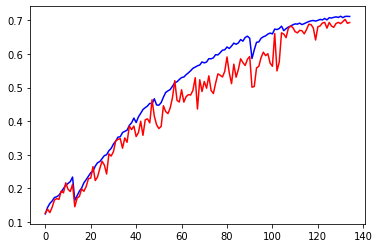

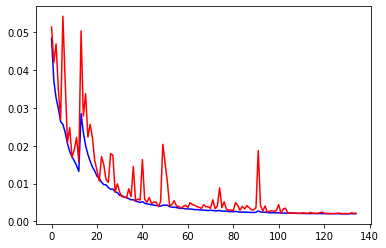

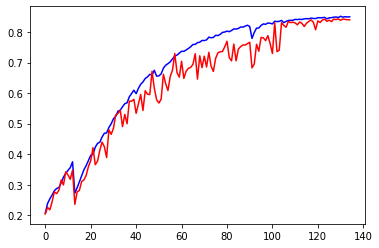

----- --------STARTING EPOCH 136-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 62ms/step - loss: 0.0017 - linear_regression_equality: 0.7294 - wide_linear_regression_equality: 0.8638 - val_loss: 0.0016 - val_linear_regression_equality: 0.7626 - val_wide_linear_regression_equality: 0.8723
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 62ms/step - loss: 0.0018 - linear_regression_equality: 0.7186 - wide_linear_regression_equality: 0.8523 - val_loss: 0.0017 - val_linear_regression_equality: 0.7205 - val_wide_linear_regression_equality: 0.8555
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 63ms/step - loss: 0.0016 - linear_regression_equality: 0.7474 - wide_linear_regression_equalit

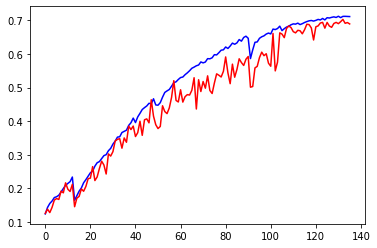

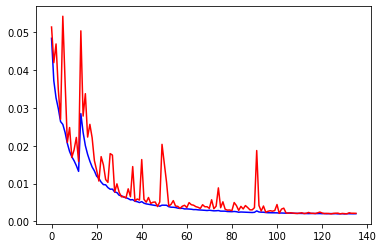

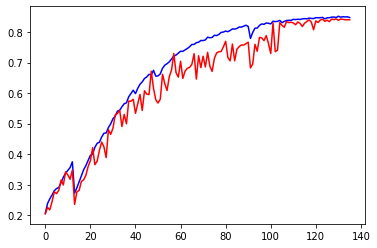

----- --------STARTING EPOCH 137-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 12s 65ms/step - loss: 0.0016 - linear_regression_equality: 0.7380 - wide_linear_regression_equality: 0.8666 - val_loss: 0.0013 - val_linear_regression_equality: 0.7695 - val_wide_linear_regression_equality: 0.8710
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 62ms/step - loss: 0.0019 - linear_regression_equality: 0.7074 - wide_linear_regression_equality: 0.8494 - val_loss: 0.0018 - val_linear_regression_equality: 0.7437 - val_wide_linear_regression_equality: 0.8570
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 65ms/step - loss: 0.0017 - linear_regression_equality: 0.7439 - wide_linear_regression_equalit

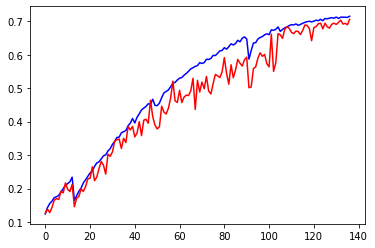

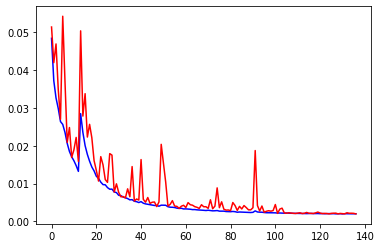

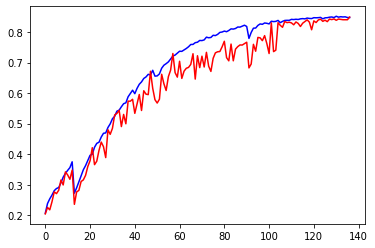

----- --------STARTING EPOCH 138-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 12s 64ms/step - loss: 0.0016 - linear_regression_equality: 0.7413 - wide_linear_regression_equality: 0.8718 - val_loss: 0.0015 - val_linear_regression_equality: 0.7591 - val_wide_linear_regression_equality: 0.8643
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 63ms/step - loss: 0.0018 - linear_regression_equality: 0.7167 - wide_linear_regression_equality: 0.8535 - val_loss: 0.0020 - val_linear_regression_equality: 0.6554 - val_wide_linear_regression_equality: 0.8502
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 62ms/step - loss: 0.0017 - linear_regression_equality: 0.7331 - wide_linear_regression_equalit

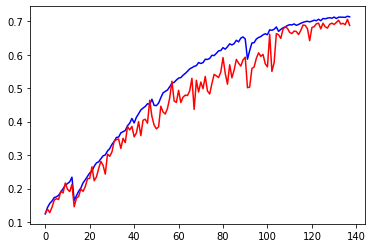

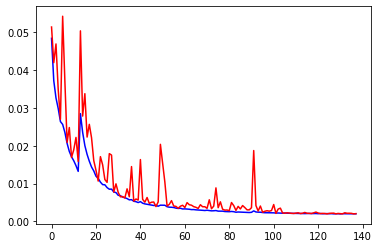

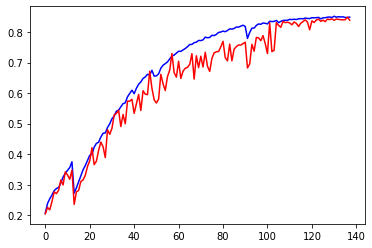

----- --------STARTING EPOCH 139-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 62ms/step - loss: 0.0016 - linear_regression_equality: 0.7333 - wide_linear_regression_equality: 0.8655 - val_loss: 0.0018 - val_linear_regression_equality: 0.7433 - val_wide_linear_regression_equality: 0.8632
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7204 - wide_linear_regression_equality: 0.8598 - val_loss: 0.0019 - val_linear_regression_equality: 0.7586 - val_wide_linear_regression_equality: 0.8629
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7402 - wide_linear_regression_equalit

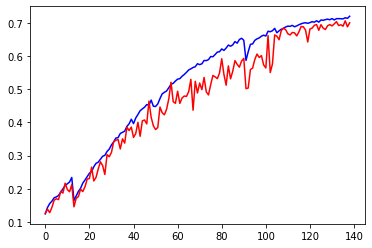

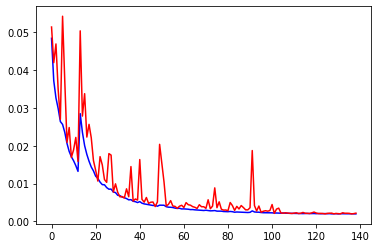

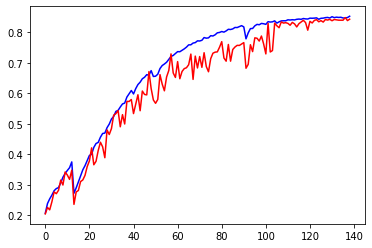

----- --------STARTING EPOCH 140-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 62ms/step - loss: 0.0016 - linear_regression_equality: 0.7378 - wide_linear_regression_equality: 0.8669 - val_loss: 0.0015 - val_linear_regression_equality: 0.7789 - val_wide_linear_regression_equality: 0.8722
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 64ms/step - loss: 0.0019 - linear_regression_equality: 0.7138 - wide_linear_regression_equality: 0.8501 - val_loss: 0.0021 - val_linear_regression_equality: 0.6364 - val_wide_linear_regression_equality: 0.8357
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 66ms/step - loss: 0.0017 - linear_regression_equality: 0.7378 - wide_linear_regression_equalit

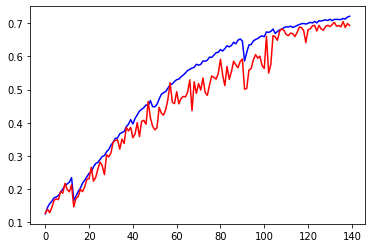

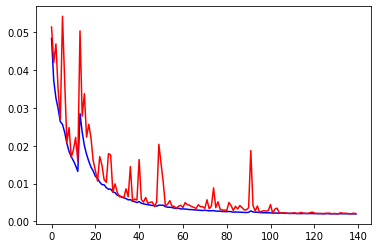

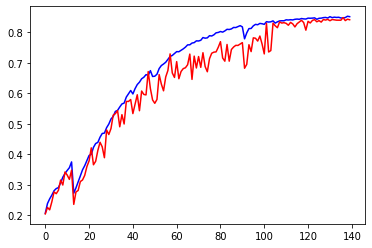

----- --------STARTING EPOCH 141-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0016 - linear_regression_equality: 0.7363 - wide_linear_regression_equality: 0.8681 - val_loss: 0.0017 - val_linear_regression_equality: 0.7591 - val_wide_linear_regression_equality: 0.8682
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 63ms/step - loss: 0.0018 - linear_regression_equality: 0.7116 - wide_linear_regression_equality: 0.8498 - val_loss: 0.0024 - val_linear_regression_equality: 0.6017 - val_wide_linear_regression_equality: 0.8297
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 62ms/step - loss: 0.0016 - linear_regression_equality: 0.7337 - wide_linear_regression_equalit

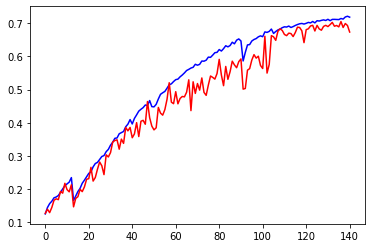

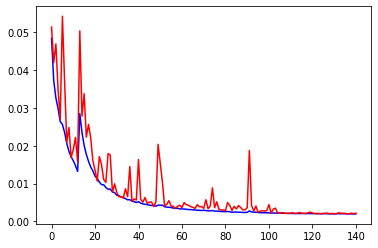

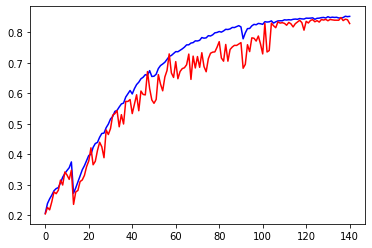

----- --------STARTING EPOCH 142-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0015 - linear_regression_equality: 0.7383 - wide_linear_regression_equality: 0.8711 - val_loss: 0.0014 - val_linear_regression_equality: 0.7763 - val_wide_linear_regression_equality: 0.8771
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7169 - wide_linear_regression_equality: 0.8515 - val_loss: 0.0023 - val_linear_regression_equality: 0.5693 - val_wide_linear_regression_equality: 0.8073
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7472 - wide_linear_regression_equalit

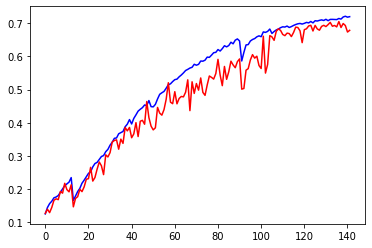

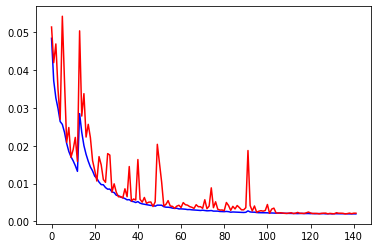

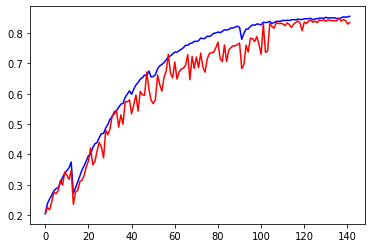

----- --------STARTING EPOCH 143-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 62ms/step - loss: 0.0016 - linear_regression_equality: 0.7352 - wide_linear_regression_equality: 0.8653 - val_loss: 0.0018 - val_linear_regression_equality: 0.7281 - val_wide_linear_regression_equality: 0.8421
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 63ms/step - loss: 0.0019 - linear_regression_equality: 0.7215 - wide_linear_regression_equality: 0.8573 - val_loss: 0.0017 - val_linear_regression_equality: 0.7498 - val_wide_linear_regression_equality: 0.8670
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 65ms/step - loss: 0.0017 - linear_regression_equality: 0.7409 - wide_linear_regression_equalit

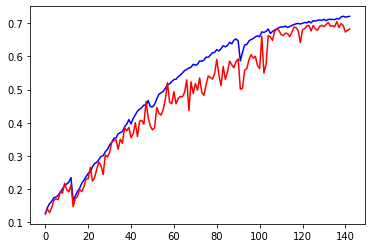

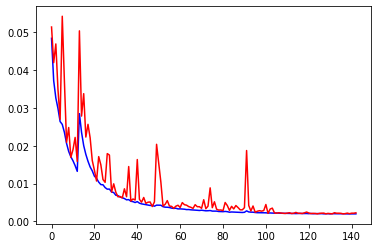

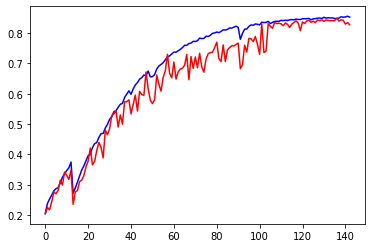

----- --------STARTING EPOCH 144-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 12s 63ms/step - loss: 0.0017 - linear_regression_equality: 0.7297 - wide_linear_regression_equality: 0.8624 - val_loss: 0.0016 - val_linear_regression_equality: 0.7677 - val_wide_linear_regression_equality: 0.8689
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 62ms/step - loss: 0.0018 - linear_regression_equality: 0.7191 - wide_linear_regression_equality: 0.8556 - val_loss: 0.0016 - val_linear_regression_equality: 0.7443 - val_wide_linear_regression_equality: 0.8786
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 62ms/step - loss: 0.0017 - linear_regression_equality: 0.7454 - wide_linear_regression_equalit

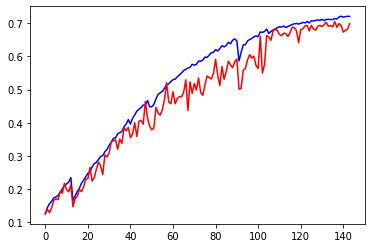

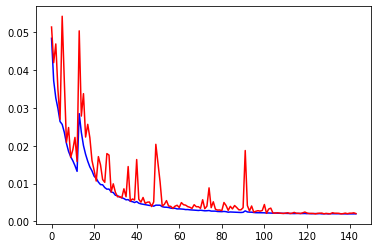

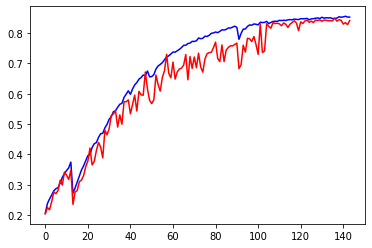

----- --------STARTING EPOCH 145-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 12s 63ms/step - loss: 0.0016 - linear_regression_equality: 0.7436 - wide_linear_regression_equality: 0.8720 - val_loss: 0.0014 - val_linear_regression_equality: 0.7710 - val_wide_linear_regression_equality: 0.8838
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 63ms/step - loss: 0.0018 - linear_regression_equality: 0.7293 - wide_linear_regression_equality: 0.8644 - val_loss: 0.0018 - val_linear_regression_equality: 0.7612 - val_wide_linear_regression_equality: 0.8698
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 62ms/step - loss: 0.0017 - linear_regression_equality: 0.7482 - wide_linear_regression_equalit

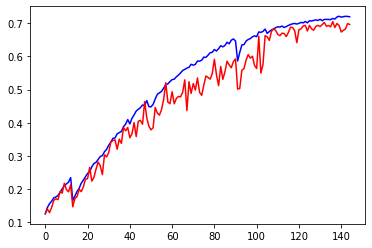

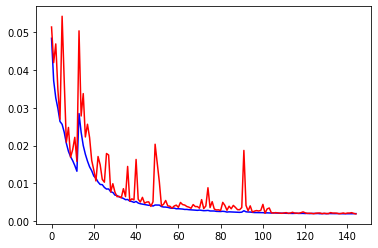

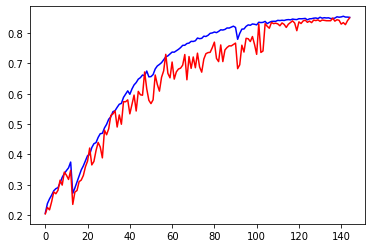

----- --------STARTING EPOCH 146-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 62ms/step - loss: 0.0016 - linear_regression_equality: 0.7401 - wide_linear_regression_equality: 0.8668 - val_loss: 0.0016 - val_linear_regression_equality: 0.7869 - val_wide_linear_regression_equality: 0.8787
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 62ms/step - loss: 0.0018 - linear_regression_equality: 0.7192 - wide_linear_regression_equality: 0.8570 - val_loss: 0.0022 - val_linear_regression_equality: 0.5768 - val_wide_linear_regression_equality: 0.8210
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7391 - wide_linear_regression_equalit

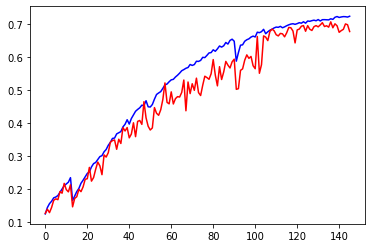

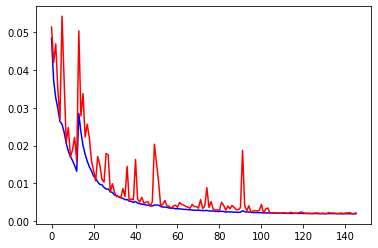

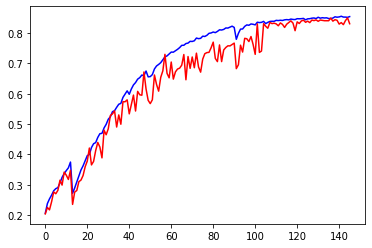

----- --------STARTING EPOCH 147-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 62ms/step - loss: 0.0017 - linear_regression_equality: 0.7387 - wide_linear_regression_equality: 0.8668 - val_loss: 0.0015 - val_linear_regression_equality: 0.7707 - val_wide_linear_regression_equality: 0.8714
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 63ms/step - loss: 0.0018 - linear_regression_equality: 0.7191 - wide_linear_regression_equality: 0.8552 - val_loss: 0.0021 - val_linear_regression_equality: 0.6960 - val_wide_linear_regression_equality: 0.8515
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 64ms/step - loss: 0.0017 - linear_regression_equality: 0.7430 - wide_linear_regression_equalit

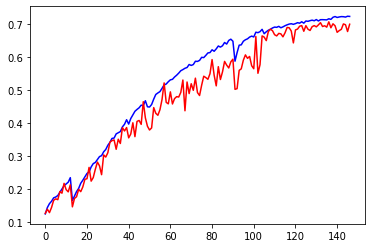

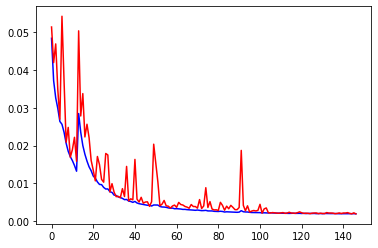

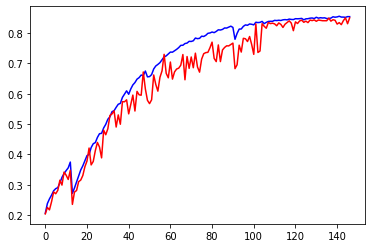

----- --------STARTING EPOCH 148-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 12s 63ms/step - loss: 0.0016 - linear_regression_equality: 0.7445 - wide_linear_regression_equality: 0.8713 - val_loss: 0.0017 - val_linear_regression_equality: 0.7607 - val_wide_linear_regression_equality: 0.8763
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 65ms/step - loss: 0.0018 - linear_regression_equality: 0.7252 - wide_linear_regression_equality: 0.8627 - val_loss: 0.0018 - val_linear_regression_equality: 0.7518 - val_wide_linear_regression_equality: 0.8583
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 64ms/step - loss: 0.0017 - linear_regression_equality: 0.7481 - wide_linear_regression_equalit

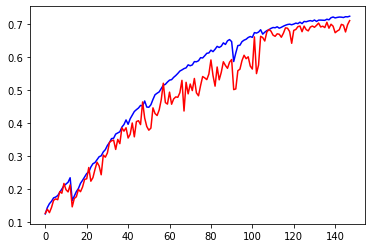

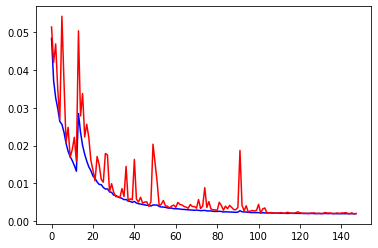

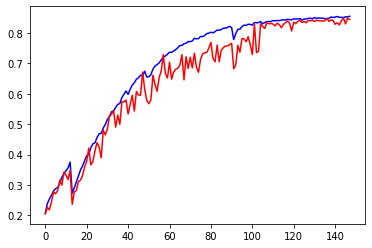

----- --------STARTING EPOCH 149-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 12s 66ms/step - loss: 0.0016 - linear_regression_equality: 0.7479 - wide_linear_regression_equality: 0.8722 - val_loss: 0.0018 - val_linear_regression_equality: 0.7499 - val_wide_linear_regression_equality: 0.8744
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 64ms/step - loss: 0.0019 - linear_regression_equality: 0.7205 - wide_linear_regression_equality: 0.8537 - val_loss: 0.0042 - val_linear_regression_equality: 0.2879 - val_wide_linear_regression_equality: 0.5877
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 63ms/step - loss: 0.0018 - linear_regression_equality: 0.7123 - wide_linear_regression_equalit

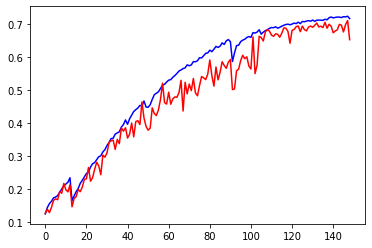

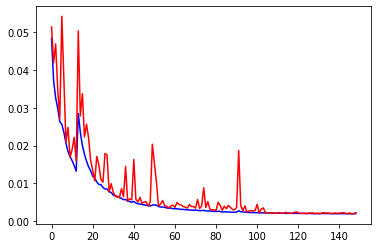

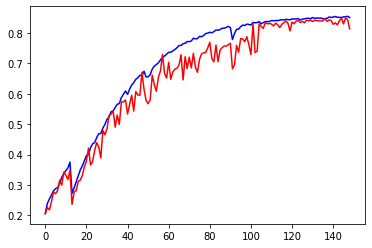

----- --------STARTING EPOCH 150-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 12s 67ms/step - loss: 0.0016 - linear_regression_equality: 0.7448 - wide_linear_regression_equality: 0.8700 - val_loss: 0.0014 - val_linear_regression_equality: 0.7787 - val_wide_linear_regression_equality: 0.8814
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 14s 67ms/step - loss: 0.0019 - linear_regression_equality: 0.7216 - wide_linear_regression_equality: 0.8569 - val_loss: 0.0017 - val_linear_regression_equality: 0.6704 - val_wide_linear_regression_equality: 0.8596
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 12s 67ms/step - loss: 0.0017 - linear_regression_equality: 0.7408 - wide_linear_regression_equalit

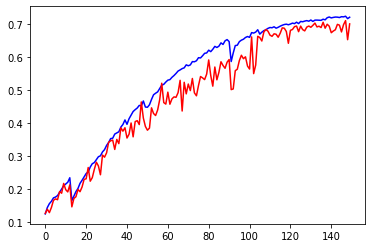

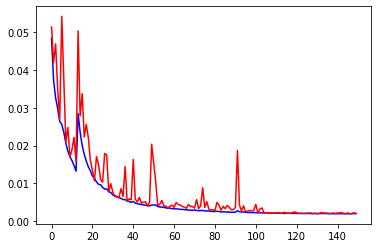

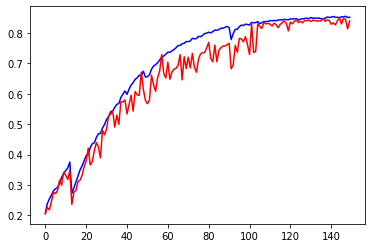

In [ ]:
# Function for training model
# Returns trained model
def train_model(EPOCHS,BATCH_SIZE):

  # Lists are initialized for training performance data
  test_acc   = []
  test_loss  = []
  train_acc  = []
  train_loss = []
  wide_train_acc = []
  wide_test_acc = []

  # Program asks user if they want to load a pretrained model
  epoch_to_load = int(input("What epoch to load? If starting training from scratch, enter 0"))
  if epoch_to_load > 0:
    # Initializes neural net
    cnn_model = build_driving_model()
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=2e-3,
        decay_steps=10000,
        decay_rate=0.95)
    optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
    cnn_model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality,wide_linear_regression_equality])
    
    # IMPORTANT: This value will be different for other users
    file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(epoch_to_load)

    # Loads weights from previous training 
    cnn_model.load_weights(file_name).expect_partial()

    # Loads performance data from past training, and plots it
    performance_data = np.load('/content/drive/MyDrive/GTA Driving Data/progress data/resnet_graph_data.npy',allow_pickle=True)
    
    train_acc = performance_data[0][0:epoch_to_load].tolist()
    test_acc = performance_data[1][0:epoch_to_load].tolist()
    train_loss = performance_data[2][0:epoch_to_load].tolist()
    test_loss = performance_data[3][0:epoch_to_load].tolist()
    wide_train_acc = performance_data[4][0:epoch_to_load].tolist()
    wide_test_acc = performance_data[5][0:epoch_to_load].tolist()
    
    # Plotting performance data
    f1 = plt.figure(figsize=(10, 10))
    f1.add_subplot(131).plot(train_acc, "-b",label = "train accuracy")
    f1.add_subplot(131).plot(test_acc, "-r",label = "test accuracy")
    f1.add_subplot(131).legend(loc='lower right')
    
    f1.add_subplot(132).plot(train_loss, "-b",label = "train loss")
    f1.add_subplot(132).plot(test_loss, "-r",label = "test loss")
    f1.add_subplot(132).legend(loc='upper right')
    
    f1.add_subplot(133).plot(wide_train_acc, "-b",label = "train accuracy (wide)")
    f1.add_subplot(133).plot(wide_test_acc, "-r",label = "test accuracy (wide)")
    f1.add_subplot(133).legend(loc='lower right')

    plt.show()

  else:
    # Initializes neural network
    cnn_model = build_driving_model()

    # Custom decaying lr schedule
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1.2e-2,
      decay_steps=10000,
      decay_rate=0.95)
    optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
    cnn_model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality,wide_linear_regression_equality])

  
  file_num_to_open = 0 
  # Number of files to be retrieved at once (to keep RAM usage low)
  num_files_to_retrieve = 20 
  # Number of files in dataset
  num_files_to_test = 233 

  # Training loop
  for epoch in range(epoch_to_load+1,EPOCHS+1):
    # Initalize empty lists for epoch performance data to be averaged
    epoch_test_acc   = []
    epoch_test_loss  = []
    epoch_train_acc  = []
    epoch_train_loss = []
    epoch_wide_train_acc  = []
    epoch_wide_test_acc  = []

    print('----- --------STARTING EPOCH {}-------------'.format(epoch))

    while file_num_to_open < num_files_to_test:
      
      # Loads data and labels
      X, Y= data_processing(file_num_to_open,num_files_to_retrieve)
      file_num_to_open += num_files_to_retrieve
      X_array = np.array(X).reshape(-1,120,160,3)
      Y_array = np.array(Y).reshape(-1,1)

      # Calling fit() to train network, history stores performance
      # 10% of data is used as validation set
      history = cnn_model.fit(X_array, Y_array, batch_size=BATCH_SIZE, epochs=1,validation_split=0.1)
      
      # Performance data is stored
      epoch_train_acc.append(history.history['linear_regression_equality'][0])
      epoch_train_loss.append(history.history['loss'][0])
      epoch_test_loss.append(history.history['val_loss'][0])
      epoch_test_acc.append(history.history['val_linear_regression_equality'][0])
      epoch_wide_test_acc.append(history.history['val_wide_linear_regression_equality'][0])
      epoch_wide_train_acc.append(history.history['wide_linear_regression_equality'][0])
    
    # Prints average performance over epoch
    print("avg train accuracy: {}".format(statistics.mean(epoch_train_acc)))
    print("avg test accuracy: {}".format(statistics.mean(epoch_test_acc)))
    print("avg train accuracy (wide): {}".format(statistics.mean(epoch_wide_train_acc)))
    print("avg test accuracy (wide): {}".format(statistics.mean(epoch_wide_test_acc)))

    # Stores average performance in lists
    train_acc.append(statistics.mean(epoch_train_acc))
    test_acc.append(statistics.mean(epoch_test_acc))
    train_loss.append(statistics.mean(epoch_train_loss))
    test_loss.append(statistics.mean(epoch_test_loss))
    wide_test_acc.append(statistics.mean(epoch_wide_test_acc))
    wide_train_acc.append(statistics.mean(epoch_wide_train_acc))
    
    #Resets file counter
    file_num_to_open = 0

    #Saves training weights and performance data every 15 epochs
    if epoch % 15 == 0:
          print("SAVED")
          file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(epoch)
          cnn_model.save_weights(file_name)
          performance_data = [train_acc,test_acc,train_loss,test_loss,wide_train_acc,wide_test_acc]
          np.save('/content/drive/MyDrive/GTA Driving Data/progress data/resnet_graph_data.npy',performance_data)

    #Plotting Performance Data
    f1 = plt.figure(figsize=(10, 3))
    fig_1 = f1.add_subplot(131)
    fig_2 = f1.add_subplot(132)
    fig_3 = f1.add_subplot(133)
    
    fig_1.plot(train_acc, "-b",label = "train accuracy")
    fig_1.plot(test_acc, "-r",label = "test accuracy")
    fig_1.legend(loc='lower right')
    
    fig_2.plot(train_loss, "-b",label = "train loss")
    fig_2.plot(test_loss, "-r",label = "test loss")
    fig_2.legend(loc='lower right')
    
    fig_3.plot(wide_train_acc, "-b",label = "train accuracy (wide)")
    fig_3.plot(wide_test_acc, "-r",label = "test accuracy (wide)")
    fig_3.legend(loc='lower right')

    plt.show()

return cnn_model

In [ ]:
# Function to test the performance of a pretrained model
# No returned values
def test_model(epochs_trained,model=None):

  if model == None:
    model = build_driving_model()
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
    # optimizer = keras.optimizers.Adam(learning_rate=5e-3)
    # model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality])

    file_location = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(epochs_trained)
    model.load_weights(file_location).expect_partial()
  
  X, Y= data_processing(0,10)
  X_array = np.array(X).reshape(-1,100,100,3)
  Y_array = np.array(Y).reshape(-1,1)

  loss, acc = model.evaluate(X_array, Y_array, verbose=2)
  print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
#Calling functions to train and test model
cnn_model = train_model(150,64)
test_model(150, cnn_model)